In [1]:
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import pybedtools as pybt
import conorm

import matplotlib.pyplot as plt
import seaborn as sns
from mycolorpy import colorlist as mcp
from matplotlib_venn import venn2,venn3

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]

# Cis-Regulatory Elements (CRE)
CREs are theoretically open chromatin regions which can be captured through ATAC-seq. 
Most well-known classes of CREs are, promoters and enhancers. 

Here we started defining them. 


In [2]:
%%bash

# 1. We generated consecutive BED files for each time point by merging 'narrow' and 'broad' peaks

### Following code was run separately, and can be find under zenodo.
#path=/groups/lackgrp/projects/col-matt-LNCaP/ProcessedDataSeo/ATAC.BED
#parallel cat $path/AT{}* '|' "awk '{if (\$9 > 10) print \$0}' " '|' cut -f1-3 '|' sort -k1,1 -k2,2n '|' bedtools merge -i - '>' data/ATAC.{}.bed  ::: Vh 30m 4h 16h 72h

cat data/ATAC.Vh.bed data/ATAC.30m.bed data/ATAC.4h.bed data/ATAC.16h.bed data/ATAC.72h.bed \
| cut -f1-3 \
| sort -k1,1 -k2,2n \
| bedtools merge -i - \
| bedtools intersect -a - -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed -v \
| awk '{print $1"\t"int(($2+$3)/2)-2500"\t"int(($2+$3)/2)+2500}' \
| grep -v '-' | grep -v '_' \
>  data/ATAC.ALL.bed

# Promoters 
The longest transcript (canonical) of transcribing (non-zero transcription) genes' +/- 2.5kb from their start-site (end-site if - stranded) of the transcript body is defined (5kb in length) as the promoter of that gene if the chromatin found accessible in ATAC.


### Collect ncbiRefSeq transcripts

In [3]:
# Here we will parse and collect the ncbiRefSeq transcripts.

!bedtools intersect -a /groups/lackgrp/genomeAnnotations/hg19/gencode.v19.annotation.gtf -b /groups/lackgrp/genomeAnnotations/hg19/hg19-blacklist.v2.bed -wa -v | uniq > /groups/lackgrp/genomeAnnotations/hg19/gencode.v19.annotation.bl.gtf
#!bedtools intersect -a /groups/lackgrp/genomeAnnotations/hg19/gencode.v19.annotation.bl.gtf -b data/ATAC.ALL.bed -wa | uniq > data/gencode.v19.annotation.bl.cre.gtf
bed = []
with open("/groups/lackgrp/genomeAnnotations/hg19/gencode.v19.annotation.bl.gtf","r") as f:
    for line in f.readlines():
        # skip comments
        if line[0] == "#":
            continue
        # parse each line and consider only 'transcript' as the type (each trascript has unique line) 
        row = line.strip().split("\t")
        Chr, type_, Start, End, Strand, meta = row[0], row[2], row[3], row[4], row[6], row[8]
        if type_ != "transcript":
            continue

        # parse and match 'gene_name' and 'transcript_id' and generate a bed line
        gene = meta[meta.index("gene_name"):].split("\"")[1]
        trns = meta[meta.index("transcript_id"):].split("\"")[1]
        bed.append((Chr, Start, End, gene, Strand, trns, type_))
        
BEDALL = pd.DataFrame(bed, columns = ["Chr", "Start", "End", "Gene", "Strand", "Transcript", 'Type']).drop_duplicates()
        

In [4]:
!cp /groups/lackgrp/projects/col-matt-LNCaP/rnaseq-pipeline/results_hg19/salmon_TPM.tsv data/RNAseq_salmon_TPM.tsv
T = pd.read_table("data/RNAseq_salmon_TPM.tsv")
T = T.set_index('Name')
MAPexp = T.mean(1).to_dict()

BEDALL['Expression'] = BEDALL['Transcript'].map(MAPexp)

BEDALL = BEDALL[~BEDALL["Expression"].isna()]

BEDALL = BEDALL.sort_values('Expression').drop_duplicates(["Gene"],keep='last').sort_values(["Chr", "Start"])

BEDALL = BEDALL[BEDALL['Expression'] != 0]

In [5]:

# 4. According to the strand info, assign start (+) or end (-) as the center of the promoter
bedpro = []
for i, row in BEDALL.iterrows():
    if row["Strand"] == "+":
        center = int(row["Start"])
    else:
        center = int(row["End"])
    bedpro.append((row["Chr"], center-2500, center+2500, row["Strand"], row["Gene"], row['Transcript'], row['Expression']))


# 5. Remove minus coordinates.  
BEDPRO = pd.DataFrame(bedpro, columns = ["Chr", "Start", "End", "Strand", "Gene",'Transcript', 'Expression']).drop_duplicates()
BEDPRO = BEDPRO[BEDPRO["Start"] > 0].reset_index(drop=True)

bedpro = pybt.BedTool.from_dataframe(BEDPRO)
cre = pybt.BedTool('data/ATAC.ALL.bed') # To overlap with Accessible sites

BEDPRO = pybt.BedTool.intersect(bedpro, cre, u=True).to_dataframe(names=["Chr", "Start", "End", "Strand", "Gene",'Transcript', 'Expression'])
BEDPRO['Name'] = BEDPRO['Chr'] +':'+ BEDPRO['Start'].astype(str) +'-'+ BEDPRO['End'].astype(str)


BEDPRO["Quartile"] = "low"
BEDPRO.loc[BEDPRO['Expression'] > np.quantile(BEDPRO['Expression'], 0.25), "Quartile"] = "Mid-low"
BEDPRO.loc[BEDPRO['Expression'] > np.quantile(BEDPRO['Expression'], 0.5), "Quartile"] = "Mid-high"
BEDPRO.loc[BEDPRO['Expression'] > np.quantile(BEDPRO['Expression'], 0.75), "Quartile"] = "High"

BEDPRO.groupby(['Quartile']).size()

Quartile
High        3363
Mid-high    3363
Mid-low     3363
low         3363
dtype: int64

### The Promoter dataset

In [6]:
BEDPRO

,Chr,Start,End,Strand,Gene,Transcript,Expression,Name,Quartile
0,chr1,10000986,10005986,+,NMNAT1,ENST00000377205.1,6.455008,chr1:10000986-10005986,Mid-low
1,chr1,100108999,100113999,+,PALMD,ENST00000263174.4,1.330391,chr1:100108999-100113999,low
2,chr1,100228849,100233849,-,FRRS1,ENST00000414213.1,2.086184,chr1:100228849-100233849,Mid-low
3,chr1,100313140,100318140,+,AGL,ENST00000361915.3,5.542713,chr1:100313140-100318140,Mid-low
4,chr1,100433035,100438035,+,SLC35A3,ENST00000427993.2,9.448050,chr1:100433035-100438035,Mid-high
...,...,...,...,...,...,...,...,...,...
13447,chrY,22735111,22740111,+,EIF1AY,ENST00000361365.2,29.262231,chrY:22735111-22740111,High
13448,chrY,2707461,2712461,+,RPS4Y1,ENST00000430575.1,199.595159,chrY:2707461-2712461,High
13449,chrY,2801046,2806046,+,ZFY,ENST00000443793.1,4.876043,chrY:2801046-2806046,Mid-low
13450,chrY,4865767,4870767,+,PCDH11Y,ENST00000333703.4,20.594298,chrY:4865767-4870767,Mid-high


### Define ANDR genes (HALLMARK_ANDROGEN_RESPONSE)

In [7]:
# 1. Parse the file.
with open("/groups/lackgrp/genomeAnnotations/hallmarks/HALLMARK_ANDROGEN_RESPONSE.v7.5.1.tsv") as f:
    for line in f.readlines():
        row = line.strip().split("\t")
        if row[0] != "MAPPED_SYMBOLS":
            continue
        else:
            hall = row[1].split(",")
            

# To remain the quartile definition of the ANDR genes, we define another file called BEDANDR. And change their definition in BEDPRO which is the promoters. 
BEDANDR = BEDPRO[BEDPRO["Gene"].isin(hall)]
BEDPRO.loc[BEDPRO["Gene"].isin(hall), 'Quartile'] = 'ANDR'


In [8]:
BEDPRO.groupby(['Quartile']).size()

Quartile
ANDR          89
High        3316
Mid-high    3341
Mid-low     3348
low         3358
dtype: int64

# FIGURE 1E

/tmp/ipykernel_42125/1117126493.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  N = N.loc[set(BEDPRO['Transcript']).intersection(set(N.index)), :]


Text(0.5, 0, '')

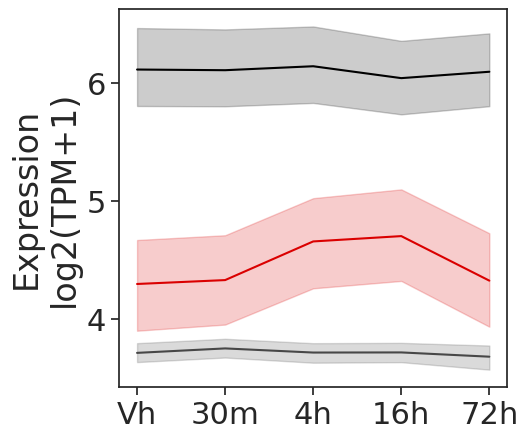

In [9]:

T["Vh"] = T[["LNCaP_Vh_1","LNCaP_Vh_2"]].mean(1)
T["30m"] = T[["LNCaP_30m_1","LNCaP_30m_2"]].mean(1)
T["4h"] = T[["LNCaP_4h_1","LNCaP_4h_2"]].mean(1)
T["16h"] = T[["LNCaP_16h_1","LNCaP_16h_2"]].mean(1)
T["72h"] = T[["LNCaP_72h_1","LNCaP_72h_2"]].mean(1)



S = np.nan_to_num(T[['Vh', '30m', '4h', '16h', '72h']])
R = 1 /(conorm.tmm_norm_factors(S) * S.sum(0) / 1000000)
N = pd.DataFrame(S * R, index=T.index, columns=['Vh', '30m', '4h', '16h', '72h'])
N = N.loc[set(BEDPRO['Transcript']).intersection(set(N.index)), :]

for h in ['Vh', '30m', '4h', '16h', '72h']:
    quarts = dict(zip(N.index, N[h]))
    BEDPRO[h] = BEDPRO["Transcript"].map(quarts)

########


sns.set(style='ticks', font_scale=2)
np.random.seed(7)
tmp = BEDPRO.groupby(['Quartile']).sample(n=89).set_index('Quartile')[['Vh', '30m', '4h','16h', '72h']].stack().reset_index()
tmp['l'] = np.log2(tmp[0]+1)

fig = plt.figure(figsize=[5,5], dpi=100)
ax = sns.lineplot(data=tmp, x='level_1', y='l', hue='Quartile', hue_order=['High', 'ANDR', 'Mid-high'], palette=['#000000', '#DA0000',  color2[-3],]) 

plt.legend([],frameon=False )
plt.ylabel('Expression\nlog2(TPM+1)')
plt.xlabel('')



#fig.savefig('../plots/ANDRinduction.pdf', bbox_inches ="tight",  pad_inches = 1 )

Text(0.5, 1.0, "ANDR Genes' Quartiles")

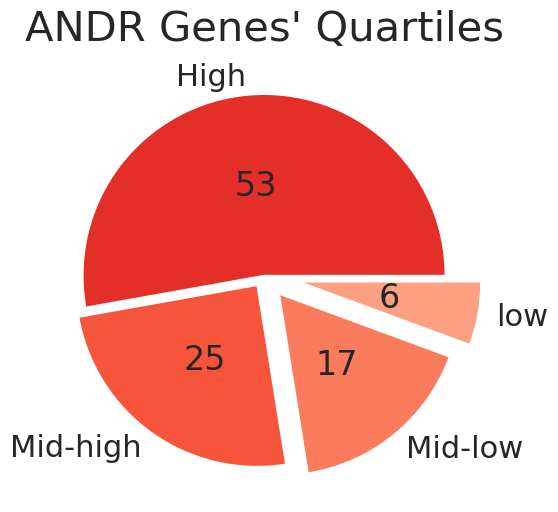

In [10]:
sns.set(style="ticks", font_scale=2)

# ANDR genes aligns in High quartlie
data = BEDANDR.groupby('Quartile').size().reset_index().sort_values(0,ascending=False)

fig = plt.figure(figsize=[6,6], dpi=100)
patches, texts, autotexts = plt.pie(
    x=data[0], 
    autopct="%.f", 
    explode=np.linspace(0,0.2, data.shape[0]),
    labels=data["Quartile"], 
    pctdistance=0.5, 
    colors=[  '#e32f27','#f6553c','#fb7c5c', '#fca082'])
plt.title('ANDR Genes\' Quartiles', fontsize=30)

#fig.savefig('../plots/ANDRQuartilePie.pdf', bbox_inches ="tight",  pad_inches = 1 )

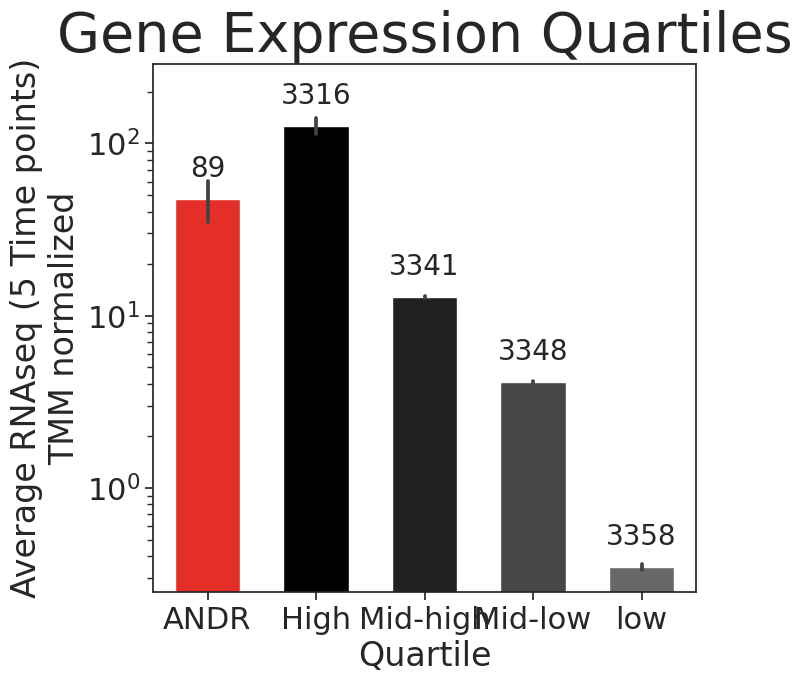

In [11]:


sns.set(style="ticks", font_scale=2)

colorPalette = ['#e32f27'] + color2[::-1]
avg = BEDPRO.groupby('Quartile').mean()['Expression'].to_list()
lab = BEDPRO.groupby('Quartile').size().to_list()

fig = plt.figure(figsize=[7,7], dpi=100)
sns.barplot(data=BEDPRO, x='Quartile', y='Expression', order=['ANDR', 'High', 'Mid-high','Mid-low','low'], palette=colorPalette, saturation=1)

for i, (t,l) in enumerate(zip(avg,lab)):
    plt.text(i, t+t/2, l, fontsize=20,ha='center',va='center')
plt.yscale('log')
plt.title('Gene Expression Quartiles', fontsize=40)
plt.ylabel('Average RNAseq (5 Time points)\nTMM normalized')
y0, y1 = plt.gca().get_ylim()
plt.ylim(y0, y1+100)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


ax = plt.gca()
change_width(ax, .6)

#fig.savefig('../plots/GeneQuartileEXP.pdf', bbox_inches ="tight",  pad_inches = 1 )

### Down-regulated

In [12]:
BEDPRO['LFC_16h'] = np.log2((BEDPRO['16h']+1) / (BEDPRO['Vh']+1) )
tmp = BEDPRO.sort_values('LFC_16h')
up = tmp.loc[tmp['LFC_16h'] > 1, 'Name'].tolist()
down = tmp.loc[tmp['LFC_16h'] < -1, 'Name'].tolist()


Counter(tmp.loc[tmp['LFC_16h'] > 1, 'Quartile']), Counter(tmp.loc[tmp['LFC_16h'] < -1, 'Quartile'])

(Counter({'Mid-low': 25, 'ANDR': 8, 'High': 4, 'low': 15, 'Mid-high': 6}),
 Counter({'low': 7, 'Mid-high': 9, 'Mid-low': 16, 'High': 4}))

/tmp/ipykernel_42125/4121231762.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


Text(0.5, 0, '')

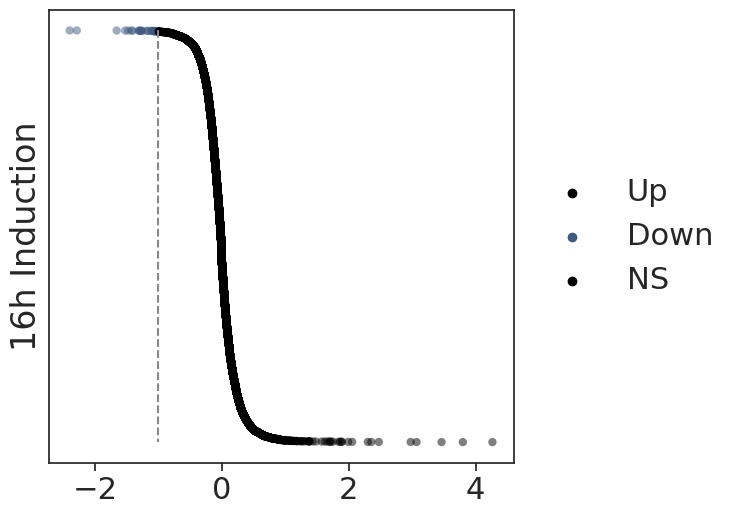

In [14]:
tmp['DE'] = 'NS'
tmp.loc[tmp['LFC_16h'] > 1, 'DE'] = 'Up'
tmp.loc[tmp['LFC_16h'] < -1, 'DE'] = 'Down'

fig = plt.figure(figsize=[6,6], dpi=100)
sns.scatterplot(data=tmp, y='Gene', x='LFC_16h', hue='DE', palette=['#000000', '#3d5a80', '#000000'], hue_order=['Up', 'Down', 'NS'], linewidth=0,alpha=0.5)
plt.yticks([])

plt.plot([-1,-1],[-2,len(tmp)+2], ls='--', c='#888888')

sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5), title='', frameon=False)

plt.ylabel('16h Induction')
plt.xlabel('')


#fig.savefig('../plots/induction_Down.pdf', bbox_inches ="tight",  pad_inches = 1 )


Text(0.5, 0, '')

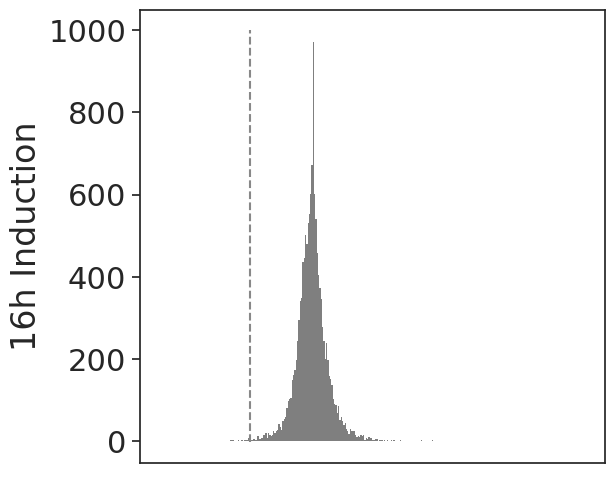

In [15]:
tmp['DE'] = 'NS'
tmp.loc[tmp['LFC_16h'] > 1, 'DE'] = 'Up'
tmp.loc[tmp['LFC_16h'] < -1, 'DE'] = 'Down'

plt.figure(figsize=[6,6], dpi=100)
sns.histplot(data=tmp, x='LFC_16h', color='#000000', linewidth=0,alpha=0.5)
plt.xticks([])

plt.plot([-1,-1],[-2,1000], ls='--', c='#888888')

plt.ylabel('16h Induction')
plt.xlabel('')




Text(0.5, 1.0, 'Down Genes')

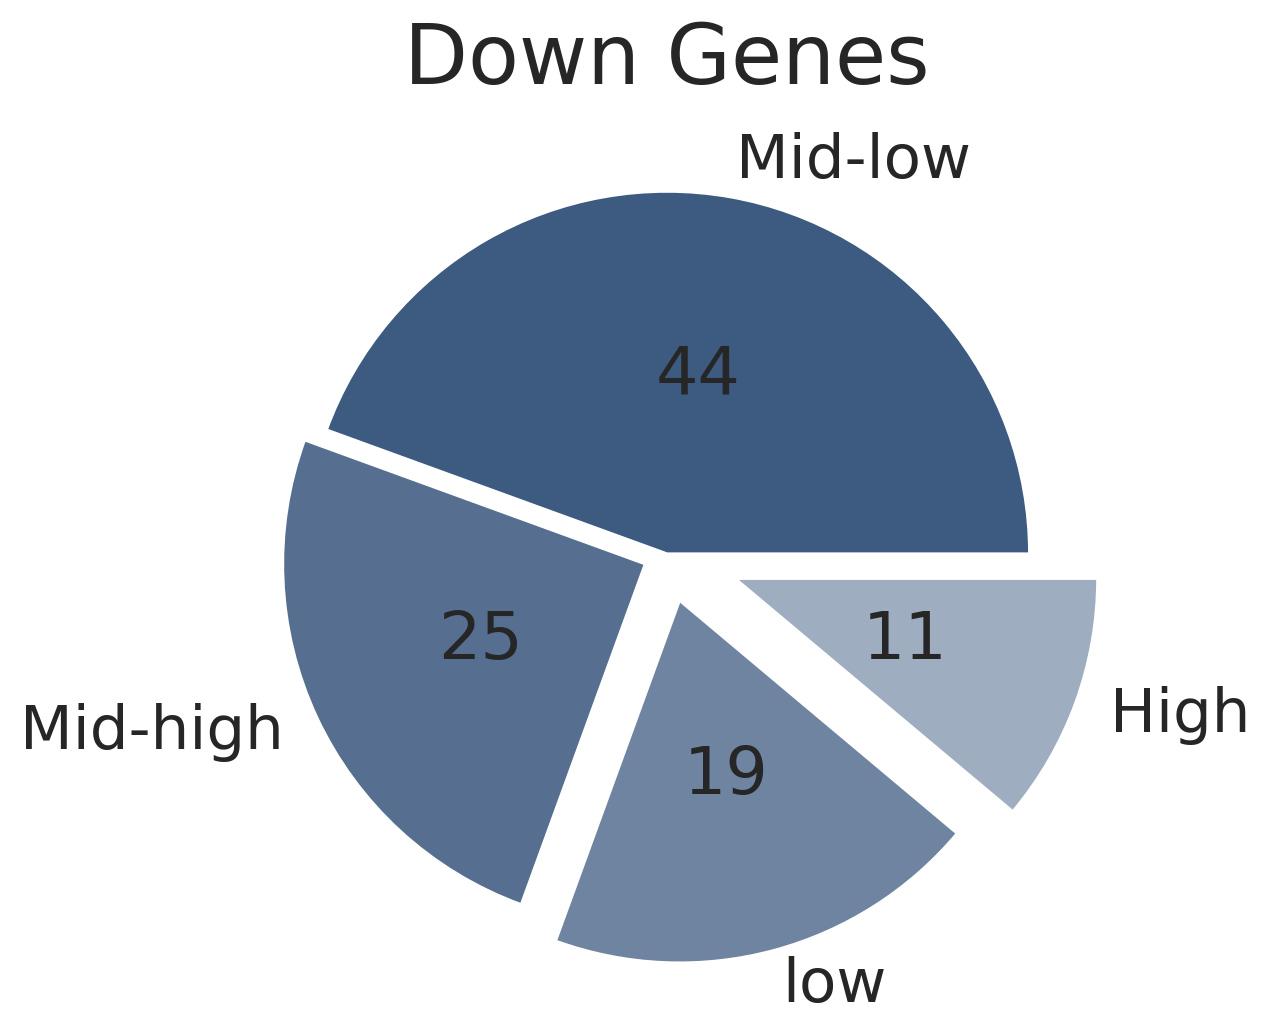

In [16]:
data = tmp[tmp['DE'] == 'Down'].groupby('Quartile').size().reset_index().sort_values(0,ascending=False)

#data = BEDANDR.groupby('Quartile').size().reset_index().sort_values(0,ascending=False)

fig = plt.figure(figsize=[6,6], dpi=200)
patches, texts, autotexts = plt.pie(
    x=data[0], 
    autopct="%.f", 
    explode=np.linspace(0,0.2, data.shape[0]),
    labels=data["Quartile"], 
    pctdistance=0.5, 
    colors=[   '#3D5A80', '#566F90', '#6E84A0','#9EADC0'])
plt.title('Down Genes', fontsize=30)

#fig.savefig('../plots/pie_Down.pdf', bbox_inches ="tight",  pad_inches = 1 )


In [17]:
pickle.dump(BEDPRO, open('zenodo/BEDPRO.p', 'wb'))

# Enhancers

Enhancers are defined according to the AR-ChIPseq and ATACseq regions. These are open chromatin regions that are not promoters (should not overlap with promoters). 
And next we split them into ARcre and cre according to AR binding.data/ATAC.ALL.bed


Generating a 3-way "venn" diagram. Please wait...


Done! Please check your results @ data/ARvsATACvsPRO. 
Thank you for using Intervene!



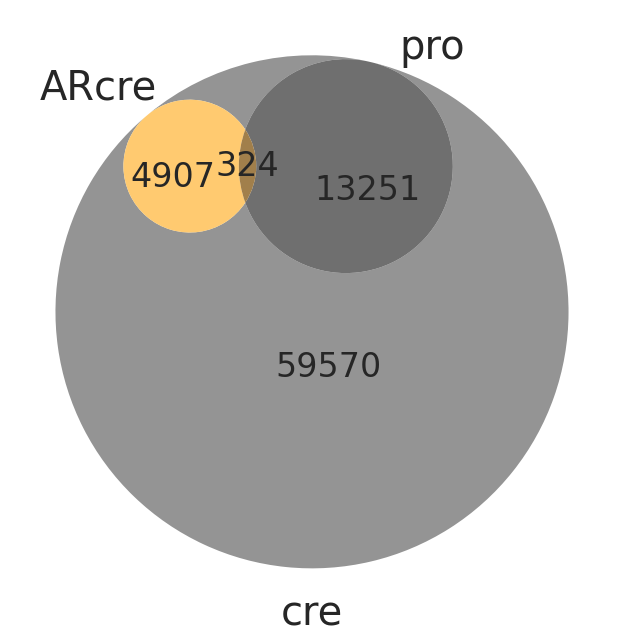

In [18]:
BEDPRO[['Chr', 'Start', 'End']].to_csv('data/PRO.bed', sep='\t', header=False, index=False)

!intervene venn -i data/ATAC.ALL.bed data/PRO.bed /groups/lackgrp/projects/col-matt-LNCaP/AR-FOXA1/DHT_AR_4hDHT.narrowPeak.bed -o data/ARvsATACvsPRO --save-overlaps

sns.set(style="ticks", font_scale=2)

fig = plt.figure(figsize=[8,8], dpi=100)

with open('data/ARvsATACvsPRO/sets/111_ATAC.ALL_PRO_DHT_AR_4hDHT.narrowPeak.bed') as f:
    n111 = len(f.readlines())

with open('data/ARvsATACvsPRO/sets/100_ATAC.ALL.bed') as f:
    n100 = len(f.readlines())
            
with open('data/ARvsATACvsPRO/sets/101_ATAC.ALL_DHT_AR_4hDHT.narrowPeak.bed') as f:
    n101 = len(f.readlines())

with open('data/ARvsATACvsPRO/sets/110_ATAC.ALL_PRO.bed') as f:
    n110 = len(f.readlines())
    
    

venn3((0,0,0,n100,n101,n110,n111), set_labels=('ARcre', 'pro', 'cre'), set_colors=('#f29201', '#000000', '#888888'), alpha=0.9)

#fig.savefig('../plots/VennCRE.pdf', bbox_inches ="tight",  pad_inches = 1 )

In [19]:
# cre: is open chromatin regions other than ARBS and PROMOTERS
cre = pd.read_table('data/ARvsATACvsPRO/sets/100_ATAC.ALL.bed', names=['Chr', 'Start', 'End'])
cre['Name'] = cre['Chr'] +':'+ cre['Start'].astype(str) +'-'+ cre['End'].astype(str)
cre['Set'] = 'cre'

# ARcre: is open chromatin regions that are bound with AR and not PROMOTERS
ARcre = pd.read_table('data/ARvsATACvsPRO/sets/101_ATAC.ALL_DHT_AR_4hDHT.narrowPeak.bed', names=['Chr', 'Start', 'End'])
ARcre['Name'] = ARcre['Chr'] +':'+ ARcre['Start'].astype(str) +'-'+ ARcre['End'].astype(str)
ARcre['Set'] = 'ARcre'

ARcrep = pd.read_table('data/ARvsATACvsPRO/sets/111_ATAC.ALL_PRO_DHT_AR_4hDHT.narrowPeak.bed', names=['Chr', 'Start', 'End'])
ARcrep['Name'] = ARcrep['Chr'] +':'+ ARcrep['Start'].astype(str) +'-'+ ARcrep['End'].astype(str)
ARcrep['Set'] = 'ARcre'

BEDENH = pd.concat((cre,ARcre, ARcrep)).reset_index(drop=True)

BEDENH[['Chr', 'Start', 'End']].to_csv('data/ENH.bed', sep='\t', header=False, index=False)
pickle.dump(BEDENH, open('data/BEDENH.p', 'wb'))

In [20]:
BEDCRE = pd.concat((BEDENH[['Chr', 'Start', 'End']], BEDPRO[['Chr', 'Start', 'End']])).sort_values(['Chr', 'Start']).reset_index(drop=True)
BEDCRE['Name'] = BEDCRE['Chr'] +':'+ BEDCRE['Start'].astype(str) +'-'+ BEDCRE['End'].astype(str)
BEDCRE.to_csv('data/CRE.bed', sep='\t', header=False, index=False)

In [ ]:
BEDCRE['Set'] = BEDCRE['Name'].map(MAPcl)
BEDCRE[BEDCRE['Set'] == 'ARcre'].to_csv('data/ARcre.bed', sep='\t', header=False, index=False)
BEDCRE[BEDCRE['Set'] == 'cre'].to_csv('data/cre.bed', sep='\t', header=False, index=False)

# These are mapping files and they are same for the entire project!

In [21]:
MAPcl = {**dict(zip(BEDENH['Name'], BEDENH['Set'])), **dict(zip(BEDPRO['Name'], BEDPRO['Quartile']))}
pickle.dump(MAPcl, open('zenodo/MAPcl.p', 'wb'))

MAPty = {**dict(zip(BEDENH['Name'], ['Enhancer']*BEDENH.shape[0])), **dict(zip(BEDPRO['Name'],  ['Promoter']*BEDPRO.shape[0]))}
pickle.dump(MAPty, open('zenodo/MAPty.p', 'wb'))

MAPgn = dict(zip(BEDPRO['Name'], BEDPRO['Gene']))
pickle.dump(MAPgn, open('zenodo/MAPgn.p', 'wb'))